In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import torch
import matplotlib.pyplot as plt

In [7]:
torch.__version__

'2.0.1'

In [16]:
class ShallowExp(torch.nn.Module):
    def __init__(self, d, m, theta=None):
        super().__init__()
        if theta == None:
            theta = torch.rand(2*m + d*m)
        self.theta = theta
        self.m = m
        self.d = d
        
    def splitter(self):
        c = self.theta[:self.m]
        b = self.theta[self.m: self.m+self.m*self.d ].reshape(self.m,self.d)
        w = self.theta[self.m+self.m*self.d:]
        return (c,b,w)
    
    def forward(self, x):
        c,b,w = self.splitter()
        diff = x.unsqueeze(2)-b.t().unsqueeze(0) # tensor with shape (npoints,d,m)
        distance = torch.norm(diff, dim=1)**2 # tensor of dimension (npoints, m)
        exp_factor = torch.exp(-w.unsqueeze(0)**2*distance)
        return torch.sum(c.unsqueeze(0)*exp_factor, dim=1).unsqueeze(1)
    
    def forward_t(self, theta, x):
        self.theta = theta
        c,b,w = self.splitter()
        diff = x.unsqueeze(2)-b.t().unsqueeze(0) # tensor with shape (npoints,d,m)
        distance = torch.norm(diff, dim=1)**2 # tensor of dimension (npoints, m)
        exp_factor = torch.exp(-w.unsqueeze(0)**2*distance)
        return torch.sum(c.unsqueeze(0)*exp_factor, dim=1).unsqueeze(1)

# Fitting a target function to a ShallowExp neural network
A ShallowExp NN is a function of the form
$$
f(x) = \sum_{i=1}^m c_i \exp^{-w_i^2 \Vert x - b_i \Vert^2}
$$
where the $c_i, w_i, b_i$ are parameters to tune.

In [9]:
d=1 # spatial dimension
m = 10 # Number of coefficients in the expansion

In [18]:
# Target function
f_true = ShallowExp(d, m)

# generate ntrain labels
ntrain = 1000
x_train=torch.rand(ntrain, d, requires_grad=True)
y_true=f_true(x_train) # Vectorized version
# y_true=torch.tensor([f_true.forward_non_vectorized(x) for x in x_train]) # Vectorized version
y_true.T

tensor([[5.5205, 5.5739, 5.6989, 5.5413, 5.8671, 5.8431, 5.8498, 5.8783, 5.6809,
         5.2675, 5.8267, 5.7253, 5.3750, 5.5842, 5.8389, 5.7506, 5.8583, 5.8466,
         5.8510, 5.8649, 5.5032, 5.8326, 5.8714, 5.7454, 5.7985, 5.8756, 5.3956,
         5.7271, 5.7973, 5.8254, 5.8227, 5.8369, 5.6790, 5.3738, 5.7213, 5.8725,
         5.5629, 5.8750, 5.8792, 5.7844, 5.8764, 5.8750, 5.6837, 5.8779, 5.4520,
         5.8628, 5.8754, 5.8758, 5.4809, 5.8791, 5.7653, 5.8026, 5.4536, 5.8626,
         5.7958, 5.8590, 5.5165, 5.6245, 5.1697, 5.8785, 5.8004, 5.3570, 5.4027,
         5.4997, 5.6360, 5.4377, 5.7817, 5.8756, 5.8782, 5.8468, 5.8122, 5.7587,
         5.8438, 5.8265, 5.8151, 5.8588, 5.8762, 5.8095, 5.3041, 5.3980, 5.5298,
         5.7551, 5.4392, 5.1973, 5.2953, 5.7737, 5.8374, 5.4671, 5.8737, 5.8786,
         5.2902, 5.8214, 5.8742, 5.6931, 5.8755, 5.7881, 5.5921, 5.8411, 5.8064,
         5.8768, 5.8530, 5.6358, 5.5406, 5.6370, 5.7979, 5.1479, 5.8785, 5.2262,
         5.2316, 5.8461, 5.3

In [13]:
# declare ShallowExp NN with m expansion coefs
model = ShallowExp(d, m)

for name, param in model.named_parameters():
    print(name)

# Current values of the model for x_train
y_pred = model(x_train) # vectorized version
y_pred.T

tensor([[5.8582, 5.7466, 5.6095, 5.8731, 5.5997, 5.9124, 5.9092, 5.7864, 5.7683,
         5.5777, 5.6673, 5.6428, 5.4816, 5.5324, 5.8912, 5.8775, 5.8280, 5.8850,
         5.7417, 5.8652, 5.9194, 5.8892, 5.8870, 5.8412, 5.7482, 5.6825, 5.8775,
         5.9170, 5.7050, 5.9170, 5.8995, 5.9127, 5.7247, 5.5596, 5.7169, 5.6198,
         5.5890, 5.6651, 5.8952, 5.9193, 5.5598, 5.9038, 5.7996, 5.9149, 5.9007,
         5.4737, 5.8230, 5.7907, 5.5137, 5.9138, 5.7762, 5.9188, 5.9039, 5.8503,
         5.8502, 5.9060, 5.8764, 5.7391, 5.8706, 5.7517, 5.8194, 5.5378, 5.6730,
         5.4880, 5.8984, 5.6924, 5.5437, 5.6735, 5.9052, 5.9195, 5.8681, 5.8136,
         5.9089, 5.6008, 5.6626, 5.5864, 5.9073, 5.8600, 5.7948, 5.8338, 5.4813,
         5.5170, 5.6099, 5.5430, 5.9096, 5.8333, 5.7168, 5.6456, 5.9048, 5.9023,
         5.8054, 5.9064, 5.5125, 5.7963, 5.4782, 5.7556, 5.4894, 5.8124, 5.7029,
         5.8993]], grad_fn=<PermuteBackward0>)

model_mini.forward(x_train

In [12]:
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs=1000

total_acc, total_loss=[], []

for epoch in range(num_epochs):
    y_pred=model(x_train)
    loss = criterion(y_pred,y_true)
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
    optimizer.zero_grad()
    print(loss)

print('\nTraining Complete')


tensor(2.4884, grad_fn=<MseLossBackward0>)
tensor(2.4724, grad_fn=<MseLossBackward0>)
tensor(2.4565, grad_fn=<MseLossBackward0>)
tensor(2.4406, grad_fn=<MseLossBackward0>)
tensor(2.4248, grad_fn=<MseLossBackward0>)
tensor(2.4091, grad_fn=<MseLossBackward0>)
tensor(2.3934, grad_fn=<MseLossBackward0>)
tensor(2.3777, grad_fn=<MseLossBackward0>)
tensor(2.3622, grad_fn=<MseLossBackward0>)
tensor(2.3466, grad_fn=<MseLossBackward0>)
tensor(2.3311, grad_fn=<MseLossBackward0>)
tensor(2.3157, grad_fn=<MseLossBackward0>)
tensor(2.3004, grad_fn=<MseLossBackward0>)
tensor(2.2851, grad_fn=<MseLossBackward0>)
tensor(2.2698, grad_fn=<MseLossBackward0>)
tensor(2.2546, grad_fn=<MseLossBackward0>)
tensor(2.2395, grad_fn=<MseLossBackward0>)
tensor(2.2245, grad_fn=<MseLossBackward0>)
tensor(2.2095, grad_fn=<MseLossBackward0>)
tensor(2.1945, grad_fn=<MseLossBackward0>)
tensor(2.1797, grad_fn=<MseLossBackward0>)
tensor(2.1649, grad_fn=<MseLossBackward0>)
tensor(2.1501, grad_fn=<MseLossBackward0>)
tensor(2.13

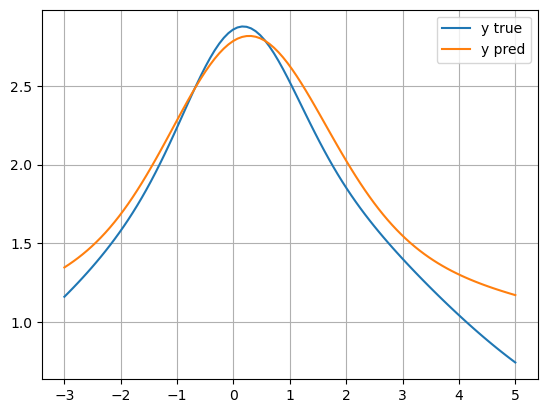

In [15]:
if d==1:
    xv = torch.linspace(-3., 5., 100)
    y_true = f_true(xv.unsqueeze(1)).detach().numpy()
    y_pred = model(xv.unsqueeze(1)).detach().numpy()
    plt.plot(xv.numpy(), y_true, label='y true')
    plt.plot(xv.numpy(), y_pred, label='y pred')
    plt.legend()
    plt.grid()
else:
    print("Warning: Plot for d>1 not supported.")